# Machine-learning Notebook - experimentation for calculating pick depth prediction from pick label classification prediction
- Machine_Learning_vB2_20170802
- A cleaner version of Machine_Learning_vB in the same folder
- preceeded by feature creation notebooks

In [5]:
import pandas as pd
import numpy as np
import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
import dask
import dask.dataframe as dd
from dask.distributed import Client
# import pdvega
# import vega
import random
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
import multiprocessing

In [7]:
print(welly.__version__)
print(dask.__version__)
print(pd.__version__)

0.3.5
0.18.2
0.23.3


In [8]:
#### Adding this bit to silence an error that was causing the notebook to have a dead kernal
#### This is an unsafe solution but couldn't get any  of the "right solutions" to work!
#### Ended up using this = https://www.kaggle.com/c/bosch-production-line-performance/discussion/25082
#### Other solutions = https://github.com/dmlc/xgboost/issues/1715 but the solution here didn't seem to work for me?


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

In [10]:
knn_dir = "../WellsKNN/"
load_dir = "../loadLAS"
features_dir = "../createFeatures/"
machine_learning_dir = "../Machine_Learning/"

## If you open this notebook fresh and jump to a point below where a pick file is read in, you still need to load everything above! 

----------

### Load dataframes for Machine-Learning via a HDF5 file

train_X
train_y
test_X
test_y

In [11]:
h5_to_load = 'df_all_Col_preSplit_wTrainTest_ClassBalanced_PreML.h5'
train_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_X')
train_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_y')
test_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_X')
test_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_y')

In [12]:
preSplitpreBal = pd.read_hdf(machine_learning_dir+h5_to_load, 'preSplitpreBal')


In [13]:
train_X.head()

,DPHI,GR,ILD,NPHI,McMurray_Base_Qual,NN1_thickness,MM_Top_Depth_predBy_NN1thick,Quality,Quality_paleoz,DistFrom_NN1_TopDepth_Abs,BotWellDept,FromTopWell,WellThickness,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge
390,0.185,101.752,3.723,0.537,2,23.78,421.84,1,2,183.096,445.994,1.0,208.25,101.752,101.752,101.752,101.752,101.7520,101.7520,101.7520,101.7520,101.752,101.752,101.752,101.752,101.752000,101.752000,101.752,101.7520,101.752,101.752,101.752,101.752,101.752000,101.752,101.752,101.752,101.752,101.752,101.752,101.752,101.75200,101.752,101.752,101.752,3.723,3.723,3.723,3.723,3.7230,3.7230,3.7230,3.7230,3.723,3.723,3.723,3.723,3.723000,3.723000,3.7230,3.7230,3.723,3.723,3.723,3.723,3.723000,3.723,3.723,3.723,3.723,3.723,3.723,3.723,3.723000,3.723,3.723,3.723
391,0.212,100.657,2.950,0.516,2,23.78,421.84,1,2,180.596,445.994,3.5,208.25,100.349,100.657,104.476,100.657,101.5134,100.6570,100.6570,100.6570,100.349,100.657,106.802,100.657,102.304429,100.657000,100.657,100.6570,100.657,100.657,100.657,100.657,100.657000,100.657,100.657,100.657,100.657,100.657,100.657,100.657,100.65700,100.657,100.657,100.657,2.950,2.950,3.254,2.950,3.1066,2.9500,2.9500,2.9500,2.950,2.950,3.414,2.950,3.194286,2.950000,2.9500,2.9500,2.950,2.950,2.950,2.950,2.950000,2.950,2.950,2.950,2.950,2.950,2.950,2.950,2.950000,2.950,2.950,2.950
392,0.175,100.744,3.409,0.532,2,23.78,421.84,1,2,178.096,445.994,6.0,208.25,99.221,100.744,106.397,106.397,102.5820,104.5656,104.5656,102.5820,99.221,100.744,106.397,100.744,103.294000,100.744000,100.744,100.7440,99.221,100.744,106.729,100.744,103.907273,100.744,100.744,100.744,100.744,100.744,100.744,100.744,100.74400,100.744,100.744,100.744,3.299,3.299,3.558,3.493,3.4230,3.3906,3.3906,3.4230,3.299,3.409,3.632,3.409,3.449143,3.409000,3.4090,3.4090,3.299,3.409,3.632,3.409,3.478455,3.409,3.409,3.409,3.409,3.409,3.409,3.409,3.409000,3.409,3.409,3.409
393,0.265,91.018,4.864,0.489,2,23.78,421.84,1,2,175.596,445.994,8.5,208.25,67.810,91.018,102.635,102.635,88.5874,98.7966,98.7966,88.5874,58.590,91.018,102.635,105.471,85.816714,100.284000,102.356,94.8634,53.847

--------------------

In [66]:
preSplitpreBal.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.098,234.808,0,0,209.808,False,False,149.602,396.102,0.25,246.25,246.5,FromTopWell,0.25,1,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.58

In [22]:
seed = 123

In [23]:
# .values.ravel()
model = XGBClassifier(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3,n_jobs=8)



In [29]:
model.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

## text here

In [13]:
result_train = model.predict(train_X)
result_train

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([  0,   0,   0, ...,  95, 100, 100])

In [14]:
train_y_indexValues = train_y.index.values
df_result_train = pd.DataFrame(result_train, index=train_y_indexValues, columns=['TopMcMr_Pick_pred'])
df_results_train_ = pd.concat([train_y, df_result_train], axis=1)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
accuracy = accuracy_score(df_results_train_['cat_isTopMcMrNearby_known'], df_results_train_['TopMcMr_Pick_pred'])

In [17]:
accuracy

0.7013336035670855

## text here 

In [18]:
result_test = model.predict(test_X)
result_test

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([ 0,  0,  0, ..., 95, 95, 95])

In [19]:
test_y_indexValues = test_y.index.values
df_result = pd.DataFrame(result_test, index=test_y_indexValues, columns=['TopMcMr_Pick_pred'])
df_results_test_ = pd.concat([test_y, df_result], axis=1)

In [20]:
accuracy = accuracy_score(df_results_test_['cat_isTopMcMrNearby_known'], df_results_test_['TopMcMr_Pick_pred'])

In [21]:
accuracy 

0.662335105335696

### test from full dataset but from training dataset again but from original dataframe so class balance is different

In [30]:
training_cols = list(train_X.columns)
training_cols

['DPHI',
 'GR',
 'ILD',
 'NPHI',
 'McMurray_Base_Qual',
 'NN1_thickness',
 'MM_Top_Depth_predBy_NN1thick',
 'Quality',
 'Quality_paleoz',
 'DistFrom_NN1_TopDepth_Abs',
 'BotWellDept',
 'FromTopWell',
 'WellThickness',
 'GR_min_5winSize_dirAroundMin',
 'GR_min_5winSize_dirAboveMin',
 'GR_min_5winSize_dirAroundMax',
 'GR_min_5winSize_dirAboveMax',
 'GR_min_5winSize_dirAroundMean',
 'GR_min_5winSize_dirAboveMean',
 'GR_min_5winSize_dirAbovenLarge',
 'GR_min_5winSize_dirAroundnLarge',
 'GR_min_7winSize_dirAroundMin',
 'GR_min_7winSize_dirAboveMin',
 'GR_min_7winSize_dirAroundMax',
 'GR_min_7winSize_dirAboveMax',
 'GR_min_7winSize_dirAroundMean',
 'GR_min_7winSize_dirAboveMean',
 'GR_min_7winSize_dirAbovenLarge',
 'GR_min_7winSize_dirAroundnLarge',
 'GR_min_11winSize_dirAroundMin',
 'GR_min_11winSize_dirAboveMin',
 'GR_min_11winSize_dirAroundMax',
 'GR_min_11winSize_dirAboveMax',
 'GR_min_11winSize_dirAroundMean',
 'GR_min_11winSize_dirAboveMean',
 'GR_min_11winSize_dirAbovenLarge',
 'GR_mi

In [31]:
training_df_origRows = preSplitpreBal[training_cols]

In [32]:
training_df_origRows.head()

,DPHI,GR,ILD,NPHI,McMurray_Base_Qual,NN1_thickness,MM_Top_Depth_predBy_NN1thick,Quality,Quality_paleoz,DistFrom_NN1_TopDepth_Abs,BotWellDept,FromTopWell,WellThickness,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge
0,0.227,102.473,0.000,0.460,1,25.0,359.66,3,1,210.058,396.102,0.00,246.5,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.263,122.589,4.202,0.550,1,25.0,359.66,3,1,209.808,396.102,0.25,246.5,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202
2,0.252,120.196,4.643,0.537,1,25.0,359.66,3,1,209.558,396.102,0.50,246.5,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643
3,0.244,115.975,5.280,0.513,1,25.0,359.66,3,1,209.308,396.102,0.75,246.5,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.9

In [33]:
len(training_df_origRows)

1482756

In [34]:
result_trainOrigRows = model.predict(training_df_origRows)
result_trainOrigRows

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 0, ..., 0, 0, 0])

In [35]:
len(result_trainOrigRows)

1482756

In [36]:
training_df_origRows_indexValues = training_df_origRows.index.values
df_result = pd.DataFrame(result_trainOrigRows, index=training_df_origRows_indexValues, columns=['TopMcMr_Pick_pred'])
df_results_train2_ = pd.concat([preSplitpreBal['cat_isTopMcMrNearby_known'], df_result['TopMcMr_Pick_pred']], axis=1)

In [39]:
accuracy = accuracy_score(df_results_train2_['cat_isTopMcMrNearby_known'], df_results_train2_['TopMcMr_Pick_pred'])

In [40]:
accuracy

0.8863919619950956

In [204]:
training_df_origRows.head()

,DPHI,GR,ILD,NPHI,McMurray_Base_Qual,NN1_thickness,MM_Top_Depth_predBy_NN1thick,Quality,Quality_paleoz,DistFrom_NN1_TopDepth_Abs,BotWellDept,FromTopWell,WellThickness,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge
0,0.227,102.473,0.000,0.460,1,25.0,359.66,3,1,210.058,396.102,0.00,246.5,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.263,122.589,4.202,0.550,1,25.0,359.66,3,1,209.808,396.102,0.25,246.5,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202,4.202
2,0.252,120.196,4.643,0.537,1,25.0,359.66,3,1,209.558,396.102,0.50,246.5,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,120.196,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643,4.643
3,0.244,115.975,5.280,0.513,1,25.0,359.66,3,1,209.308,396.102,0.75,246.5,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.975,115.9

In [205]:
len(training_df_origRows)

1482756

--------

## Go from classifiers on rows to single pick per well and error bars

In [31]:
!ls

Machine_Learning_PostSplit_vA_20180804.ipynb
Machine_Learning_vA_20170726.ipynb
Machine_Learning_vB2_20170802-Copy1.ipynb
Machine_Learning_vB2_20170802.ipynb
Machine_Learning_vC_20170802.ipynb
dask-worker-space
df_all_Col_preSplit_wTrainTest_ClassBalanced_PreML.h5
old_vB.ipynb


In [32]:
s = pd.Series([0, 0, 10, 10, 95, 10,0])

In [33]:
s.rolling(2).quantile(.5, interpolation='midpoint')

0     NaN
1     0.0
2     5.0
3    10.0
4    52.5
5    52.5
6     5.0
dtype: float64

In [34]:
s.quantile(0.5)

10.0

In [35]:
y = pd.Series([0, 0, 0, 0, 0, 0, 0, 10, 95,100,100,10,10,10,10,10,100,100,100,100,0 ,0 ,0 ,0 ])
x = pd.Series([10,11,12,13,14,15,16,17 ,18 ,19 ,20,21,22,23,24,25,26 , 27, 28,29, 30,31,32,33])

In [36]:
sum(y)

755

In [37]:
def findMiddle(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
    print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
        half_y = sum(y)/2
        print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
            print("i=",i)
            temp_sum = y[i] + temp_sum
            print("temp_sum",temp_sum)
            if(temp_sum >= half_y):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [38]:
test = findMiddle(x,y)
test

x_len = 24  and y_len is  24
avg_y 377.5
i= 0
temp_sum 0
i= 1
temp_sum 0
i= 2
temp_sum 0
i= 3
temp_sum 0
i= 4
temp_sum 0
i= 5
temp_sum 0
i= 6
temp_sum 0
i= 7
temp_sum 10
i= 8
temp_sum 105
i= 9
temp_sum 205
i= 10
temp_sum 305
i= 11
temp_sum 315
i= 12
temp_sum 325
i= 13
temp_sum 335
i= 14
temp_sum 345
i= 15
temp_sum 355
i= 16
temp_sum 455


26

In [39]:
def changeClassValues_partA(array_value):
    """
    Takes in an array, an array of values found in the first array, such as 0,10,50,100, and an array of ouputs of same lengh as inputs to that represents their new values
    For example, an array of values that are always 0, 60,95,100, such as [0,0,0,60,60,60,95,100,95,95,60,0,0] could be changed into values of 0s,10s,80s,and 100s. [0,0,0,10,10,10,80,100,80,80,10,0,0]
    One use case of this is to change the relative strength of each class when using it as labels or features or when calculating the weighted middle instance.
    """
    array_inputs = [0,10,60,95,100]
    array_outputs = [0,1,2,3,4]
    length_ofInputs = len([0,10,60,95,100])
    for i in range(length_ofInputs):
        if array_inputs[i] == array_value:
            return array_outputs[i]
    print("did not find a match between input array and output for given argument in changeClassValues_partA")
    return 0
        

In [40]:
test = changeClassValues_partA(95)
test

3

 apply this to a series = changeClassValues(array_value,array_inputs,array_outputs)

In [41]:
changeClassValues_partB = np.vectorize(changeClassValues_partA) #Convert python function to vector function
test2 = np.apply_along_axis(changeClassValues_partB, 0,[0, 0, 10, 10, 95, 10,0,95,100,100,60,60,0,0,0,0])
print(test2)

[0 0 1 1 3 1 0 3 4 4 2 2 0 0 0 0]


## Find median values of each prediction array + depth array of each well

In [42]:
df_results_train_.describe()

,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
count,246700.000000,246700.000000
mean,45.229712,43.371585
std,43.793369,43.146057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,60.000000,60.000000
75%,95.000000,95.000000
max,100.000000,100.000000


In [43]:
df_results_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246700 entries, 390 to 307647
Data columns (total 2 columns):
cat_isTopMcMrNearby_known    246700 non-null int64
TopMcMr_Pick_pred            246700 non-null int64
dtypes: int64(2)
memory usage: 5.6 MB


In [44]:
df_results_train_.head()

,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
390,0,0
391,0,0
392,0,0
393,0,0
394,0,0


In [45]:
df_results_train2_.head()

,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [46]:
preSplitpreBal.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.098,234.808,0,0,209.808,False,False,149.602,396.102,0.25,246.25,246.5,FromTopWell,0.25,1,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.58

In [47]:
len(preSplitpreBal)

1482756

In [48]:
df_results_train2_FullCol = pd.concat([preSplitpreBal,df_results_train2_], axis=1)

In [49]:
df_results_train2_FullCol.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test,0,0
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.098,234.808,0,0,209.808,False,False,149.602,396.102,0.25,246.25,246.5,FromTopWell,0.25,1,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.58

In [50]:
len(df_results_train2_FullCol)

1482756

In [51]:
# df[['color', 'food', 'score']]
test_df = df_results_train2_FullCol[['UWI','DEPT','cat_isTopMcMrNearby_known','TopMcMr_Pick_pred']]

In [52]:
test_df

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,00/10-32-080-20W4/0,149.602,0,0,0
1,00/10-32-080-20W4/0,149.852,0,0,0
2,00/10-32-080-20W4/0,150.102,0,0,0
3,00/10-32-080-20W4/0,150.352,0,0,0
4,00/10-32-080-20W4/0,150.602,0,0,0
5,00/10-32-080-20W4/0,150.852,0,0,0
6,00/10-32-080-20W4/0,151.102,0,0,0
7,00/10-32-080-20W4/0,151.352,0,0,0
8,00/10-32-080-20W4/0,151.602,0,0,0
9,00/10-32-080-20W4/0,151.852,0,0,0


In [53]:
test_df.columns = ['UWI','DEPT','cat_isTopMcMrNearby_known','cat_isTopMcMrNearby_known_2','TopMcMr_Pick_pred']
test_df.head()

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred
0,00/10-32-080-20W4/0,149.602,0,0,0
1,00/10-32-080-20W4/0,149.852,0,0,0
2,00/10-32-080-20W4/0,150.102,0,0,0
3,00/10-32-080-20W4/0,150.352,0,0,0
4,00/10-32-080-20W4/0,150.602,0,0,0


# Got too tired and stopped here

In [54]:
mean_test_df = test_df['cat_isTopMcMrNearby_known'].groupby(test_df['UWI']).mean()

In [55]:
mean_test_df

UWI
00/01-01-073-05W5/0     2.353506
00/01-03-085-15W4/0     4.208494
00/01-04-075-23W4/0     2.984166
00/01-05-085-15W4/0     3.398058
00/01-08-080-21W4/0     2.606383
00/01-09-080-13W4/0     2.660152
00/01-10-078-26W4/0     2.549428
00/01-11-082-23W4/0     2.819333
00/01-12-079-14W4/0     2.660152
00/01-21-084-17W4/0     3.154312
00/01-24-075-24W4/0     2.603613
00/01-25-083-02W4/0     2.848837
00/01-26-068-08W4/0     2.719201
00/01-27-079-23W4/0     2.549428
00/01-27-080-14W4/0     2.606383
00/01-28-078-02W4/0     2.367195
00/01-32-080-22W4/0     2.784091
00/02-01-074-05W5/0     2.353506
00/02-02-083-11W4/0     2.719201
00/02-03-071-04W5/0     4.425087
00/02-05-076-26W4/0     0.860495
00/02-06-074-04W5/0     2.399608
00/02-07-076-13W4/0     2.660152
00/02-08-078-02W5/0     2.447552
00/02-14-077-04W4/0     2.225250
00/02-17-079-03W4/0     2.353506
00/02-18-077-13W4/0     2.581665
00/02-22-071-22W4/0     3.137004
00/02-25-077-10W4/0     2.549428
00/02-26-072-13W4/0     2.660152
00/02-

In [200]:
UWIs = test_df.UWI.unique()

In [201]:
list(UWIs)

['00/10-32-080-20W4/0',
 '00/04-15-081-09W4/0',
 '00/07-23-076-22W4/0',
 '00/11-19-073-16W4/0',
 '00/06-19-089-18W4/0',
 '00/11-11-080-19W4/0',
 '00/06-25-082-09W4/0',
 '00/06-31-067-15W4/0',
 'AA/07-29-093-13W4/0',
 '00/11-21-077-07W4/0',
 '00/07-26-074-05W4/0',
 '00/12-19-075-09W4/0',
 'AA/11-09-096-11W4/0',
 '00/10-22-076-03W4/0',
 'AA/02-24-091-12W4/0',
 '00/05-29-078-19W4/0',
 'AA/11-33-094-06W4/0',
 '00/10-27-076-11W4/0',
 '00/07-26-080-02W5/0',
 '00/11-26-080-16W4/0',
 '00/06-08-074-01W4/0',
 '00/06-08-074-11W4/0',
 '00/07-21-081-21W4/0',
 '00/11-30-073-13W4/0',
 '00/11-24-084-25W4/0',
 '00/05-09-070-05W4/0',
 '00/11-23-080-04W4/0',
 '00/10-34-069-05W4/0',
 '00/06-06-074-19W4/0',
 'AA/10-08-089-14W4/0',
 '00/10-34-069-15W4/0',
 '00/08-24-070-04W5/0',
 '00/11-07-068-17W4/0',
 '00/10-34-078-23W4/0',
 '00/03-01-077-05W4/0',
 '00/07-17-070-15W4/0',
 'AA/05-36-094-09W4/0',
 '00/11-36-067-13W4/0',
 '00/11-35-094-16W4/0',
 '00/06-29-068-04W4/0',
 '00/06-17-076-10W4/0',
 '00/06-16-083-1

In [104]:
test_df_1well = test_df[test_df['UWI']=='00/11-18-079-03W5/0']

In [105]:
len(test_df_1well)

513

In [106]:
test_df_1well.head()

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred
1481362,00/11-18-079-03W5/0,484.632,0,0,0
1481363,00/11-18-079-03W5/0,484.882,0,0,0
1481364,00/11-18-079-03W5/0,485.132,0,0,0
1481365,00/11-18-079-03W5/0,485.382,0,0,0
1481366,00/11-18-079-03W5/0,485.632,0,0,0


In [107]:
array_ = test_df_1well['TopMcMr_Pick_pred'].values

In [108]:
new_series = np.apply_along_axis(changeClassValues_partB, 0,test_df_1well['TopMcMr_Pick_pred'].values)

In [109]:
new_series

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [110]:
predicted_from_median_pick = findMiddle(test_df_1well['DEPT'].values,test_df_1well['TopMcMr_Pick_pred'].values)

x_len = 513  and y_len is  513
avg_y 4637.5
i= 0
temp_sum 0
i= 1
temp_sum 0
i= 2
temp_sum 0
i= 3
temp_sum 0
i= 4
temp_sum 0
i= 5
temp_sum 0
i= 6
temp_sum 0
i= 7
temp_sum 0
i= 8
temp_sum 0
i= 9
temp_sum 0
i= 10
temp_sum 0
i= 11
temp_sum 0
i= 12
temp_sum 0
i= 13
temp_sum 0
i= 14
temp_sum 0
i= 15
temp_sum 0
i= 16
temp_sum 0
i= 17
temp_sum 0
i= 18
temp_sum 0
i= 19
temp_sum 0
i= 20
temp_sum 0
i= 21
temp_sum 0
i= 22
temp_sum 0
i= 23
temp_sum 0
i= 24
temp_sum 0
i= 25
temp_sum 0
i= 26
temp_sum 0
i= 27
temp_sum 0
i= 28
temp_sum 0
i= 29
temp_sum 0
i= 30
temp_sum 0
i= 31
temp_sum 0
i= 32
temp_sum 0
i= 33
temp_sum 0
i= 34
temp_sum 0
i= 35
temp_sum 0
i= 36
temp_sum 0
i= 37
temp_sum 0
i= 38
temp_sum 0
i= 39
temp_sum 0
i= 40
temp_sum 0
i= 41
temp_sum 0
i= 42
temp_sum 0
i= 43
temp_sum 0
i= 44
temp_sum 0
i= 45
temp_sum 0
i= 46
temp_sum 0
i= 47
temp_sum 0
i= 48
temp_sum 0
i= 49
temp_sum 0
i= 50
temp_sum 0
i= 51
temp_sum 0
i= 52
temp_sum 0
i= 53
temp_sum 0
i= 54
temp_sum 0
i= 55
temp_sum 0
i= 56
temp_sum

In [111]:
predicted_from_median_pick

594.382

# IT looks like the depth returned is the last one, which means our function is not calculating things correctly?

In [112]:
test_df_1well

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred
1481362,00/11-18-079-03W5/0,484.632,0,0,0
1481363,00/11-18-079-03W5/0,484.882,0,0,0
1481364,00/11-18-079-03W5/0,485.132,0,0,0
1481365,00/11-18-079-03W5/0,485.382,0,0,0
1481366,00/11-18-079-03W5/0,485.632,0,0,0
1481367,00/11-18-079-03W5/0,485.882,0,0,0
1481368,00/11-18-079-03W5/0,486.132,0,0,0
1481369,00/11-18-079-03W5/0,486.382,0,0,0
1481370,00/11-18-079-03W5/0,486.632,0,0,0
1481371,00/11-18-079-03W5/0,486.882,0,0,0


In [113]:
UWI_of_well = test_df_1well['UWI'][0:1].values[0]
UWI_of_well

'00/11-18-079-03W5/0'

In [114]:
preSplitpreBal['McMurray_Top_DEPTH']

0          377.95
1          377.95
2          377.95
3          377.95
4          377.95
5          377.95
6          377.95
7          377.95
8          377.95
9          377.95
10         377.95
11         377.95
12         377.95
13         377.95
14         377.95
15         377.95
16         377.95
17         377.95
18         377.95
19         377.95
20         377.95
21         377.95
22         377.95
23         377.95
24         377.95
25         377.95
26         377.95
27         377.95
28         377.95
29         377.95
30         377.95
31         377.95
32         377.95
33         377.95
34         377.95
35         377.95
36         377.95
37         377.95
38         377.95
39         377.95
40         377.95
41         377.95
42         377.95
43         377.95
44         377.95
45         377.95
46         377.95
47         377.95
48         377.95
49         377.95
50         377.95
51         377.95
52         377.95
53         377.95
54         377.95
55        

In [115]:
real_pick_depth = preSplitpreBal.loc[preSplitpreBal['UWI'] == test_df_1well['UWI'][0:1].values[0]]['McMurray_Top_DEPTH'][0:1].values[0]

In [116]:
real_pick_depth

578.21

In [117]:
pred_diff_real_TopMcMr = real_pick_depth - predicted_from_median_pick
pred_diff_real_TopMcMr

-16.171999999999912

--------

#### Use mean of rolling window instead?

In [121]:
test_df_1well.head()

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred
1481362,00/11-18-079-03W5/0,484.632,0,0,0
1481363,00/11-18-079-03W5/0,484.882,0,0,0
1481364,00/11-18-079-03W5/0,485.132,0,0,0
1481365,00/11-18-079-03W5/0,485.382,0,0,0
1481366,00/11-18-079-03W5/0,485.632,0,0,0


In [185]:
# test_df_1well = test_df_1well.drop(['rollingMeanTopMcMrPred_10','rollingMeanTopMcMrPred_5','rollingMeanTopMcMrPred_5plus10'], axis=1)

In [186]:
test_df_1well = test_df_1well.drop(['rollingMeanTopMcMrPred_6plus12'], axis=1)

In [187]:
test_df_1well['rollingMeanTopMcMrPred_12'] = test_df_1well.TopMcMr_Pick_pred.shift(-6).rolling(12).mean().fillna(0)

In [188]:
test_df_1well['rollingMeanTopMcMrPred_6'] = test_df_1well.TopMcMr_Pick_pred.shift(-3).rolling(6).mean().fillna(0)

In [189]:
test_df_1well['rollingMeanTopMcMrPred_20'] = test_df_1well.TopMcMr_Pick_pred.shift(-10).rolling(20).mean().fillna(0)

In [190]:
test_df_1well['rollingMeanTopMcMrPred_6plus12plus20'] = test_df_1well['rollingMeanTopMcMrPred_6'] + test_df_1well['rollingMeanTopMcMrPred_12'] + test_df_1well['rollingMeanTopMcMrPred_20']

In [191]:
test_df_1well

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred,rollingMeanTopMcMrPred,rollingMeanTopMcMrPred_12,rollingMeanTopMcMrPred_6,rollingMeanTopMcMrPred_20,rollingMeanTopMcMrPred_6plus12plus20
1481362,00/11-18-079-03W5/0,484.632,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481363,00/11-18-079-03W5/0,484.882,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481364,00/11-18-079-03W5/0,485.132,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481365,00/11-18-079-03W5/0,485.382,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481366,00/11-18-079-03W5/0,485.632,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481367,00/11-18-079-03W5/0,485.882,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481368,00/11-18-079-03W5/0,486.132,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481369,00/11-18-079-03W5/0,486.382,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481370,00/11-18-079-03W5/0,486.632,0,0,0,0.0,0.000000,0.000000,0.00,0.000000
1481371,00/11-18-079-03W5/0,486.882,0,0,0,0.0,0.000000,0.000000,0.00,0.000000


In [192]:
max_test = test_df_1well['rollingMeanTopMcMrPred_6plus12plus20'].max()

In [193]:
max_test 

281.5

In [194]:
max_pred_rows = test_df_1well.loc[test_df_1well['rollingMeanTopMcMrPred_6plus12plus20'] == max_test ]

In [195]:
max_pred_rows

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known_2,TopMcMr_Pick_pred,rollingMeanTopMcMrPred,rollingMeanTopMcMrPred_12,rollingMeanTopMcMrPred_6,rollingMeanTopMcMrPred_20,rollingMeanTopMcMrPred_6plus12plus20
1481832,00/11-18-079-03W5/0,602.132,0,0,95,95.0,95.0,95.0,91.5,281.5


In [196]:
max_pred_row_depth = max_pred_rows['DEPT']

In [199]:
pred_diff_realBigRolling_TopMcMr = real_pick_depth - max_pred_row_depth
pred_diff_realBigRolling_TopMcMr

1481832   -23.922
Name: DEPT, dtype: float64

## Perhaps I'll make a few different predictions from the classifiers:
- Median
- Rolling mean 6
- Rolling mean 12
- Rolling Mean 20
- Sums of rolling all means 
## I can try to vary the differences between the classes by changing 100 to 150 or something?
## It would likely be useful to have some error bars as well! 
- One model would be plus or minus generated from greatest distance on either side there is anything other than zero?
- Another model would be to do same thing as above but only only use 95 class

-------------------

# Well by well calculation of single point predictions from classification prediction

https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [41]:
def findMiddleOfPreClassif(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
#     print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
#         print("type y",type(y))
#         print("len y",len(y))
#         print("y",y)
        half_y = sum(y)*0.5
#         print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
#             print("i=",i)
            temp_sum = y[i][0] + temp_sum
#             print("temp_sum",temp_sum)
            if(temp_sum >= half_y[0]):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [42]:
df_results_train2_FullCol_vB = pd.concat([preSplitpreBal,df_results_train2_], axis=1)

In [43]:
df_results_train2_FullCol_vB.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test,0,0
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.098,234.808,0,0,209.808,False,False,149.602,396.102,0.25,246.25,246.5,FromTopWell,0.25,1,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.58

In [56]:
def calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
    """
    Function takes in:
        A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
    Function returns:
        A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
        A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
        A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
        A new col in the new df that has high and low error by some metric?
        A score of mean abosolute error across all wells in the given dataframe 1.
    """
#     df['testA'] = df.groupby(['UWI'])['TopMcMr_Pick_pred'].shift(-6).rolling(12).mean().fillna(0)
#     print("df['testA']",df['testA'])
    #### Get all UWIs in prediction dataframe
    #pre_UWI = list(df_pred.UWI.unique())
    #### Copy given dataframe into a new dataframe
#     df_new = df.copy()
    #### Groupby UWI
#     df_new_gb = df_new.groupby([UWI_str])
#     #### Calculate median predictions as new col
#     df_new_gb_P50_results = df_new_gb.apply(lambda x: findMiddleOfPreClassif(x[depth_str].values,x[pick_pred_class_str].values))
#     df_new_gb_P50_results = df_new_gb_P50_results.reset_index()
#     p50_name = pick_pred_class_str+'_P50'
#     df_new_gb_P50_results.columns = [UWI_str, p50_name]
#     df_merges = pd.merge(df,df_new_gb_P50_results, on=UWI_str, how='outer')
    
    df_merges = df.copy()
#     print(df_merges, "= df_merges")
#     df_merges['test_0'] = 0
#     print("df_merges['test_0']",df_merges['test_0'])
    #### calculate rolling mean predictions as new columns
    #### predClasses should be an array of the predicted top classes like [0,60,95,100]
    #### rolling windows should be an array like [6,12,20]
    all_new_rolling_mean_col = []
#     print("test_1",df_merges.groupby([UWI_str]).head())
#     df_merges['test'] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(-3).rolling(6).mean().fillna(0)
#     print("df_merges['test']",df_merges['test'])
    for Window in rollingWindows:
        new_col = pick_pred_class_str+'_classRollMean'+str(Window)
        all_new_rolling_mean_col.append(new_col)
        half_window_neg = -1*math.floor(Window/2)
        df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
    df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
    for col in all_new_rolling_mean_col:
        #print("col",col)
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
    df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
    #print(df_merges[pick_pred_class_str+'classRollMeanSum'])
    # Combo sum of both rolling means and p50 position
#     df_merges[pick_pred_class_str+'classRollMeanP50Sum'] += df_merges[p50_name]
    
    #### DO THESE LATER
        #### calculate high-end error using 60s
        #### calculate low-end error using 60s
        #### calculate high-end error using 95s
        #### calculate low-end error using 95s
    
    #### if 100s present but only one 100, use that as prediction depth
    
    #### temp return single number!
    #max_series = df_merges.groupby(['UWI'])[pick_pred_class_str+'classRollMeanSum'].max()
    #idx = df_merges.groupby(['UWI'])[pick_pred_class_str+'classRollMeanSum'].transform(max) == df_merges[pick_pred_class_str+'classRollMeanSum']
    idx = df_merges.loc[df_merges.groupby(["UWI"])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
    #print('idx=',idx)
    print('type(idx)',type(idx))
#     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
    max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
    max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'classRollMeanSum']
    #print("type",type(max_series),"and max series is ",max_series)
    #max_series = max_series.to_frame()
    df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
        
    #### If checking rolling 6 to see if only one is max:
        #### If so, use that as pred depth
        #### If not, look at rolling 6 + median to see if one is max, if so use it
        #### If not, look at rolling 6 + 12 + 20 + median to see if one is max, if so use it
        #### If not use median depth as single prediction
    return df_merges
    

In [57]:
# calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses)

In [87]:
calc_pred = calcPredVsRealTopDif(df_results_train2_FullCol_vB,'DEPT','TopMcMr_Pick_pred','UWI',[4,6,22],[0,60,95,100])

type(idx) <class 'pandas.core.frame.DataFrame'>


In [88]:
calc_pred.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,TopMcMr_Pick_pred_classRollMean4,TopMcMr_Pick_pred_classRollMean6,TopMcMr_Pick_pred_classRollMean22,TopMcMr_Pick_predclassRollMeanSum_x,TopMcMr_Pick_pred_DEPT_pred,TopMcMr_Pick_predclassRollMeanSum_y
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test,0,0,0.0,0.0,0.0,0.0,370.852,374.621212
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.6

In [89]:
# accuracy = accuracy_score(calc_pred['McMurray_Top_DEPTH'], calc_pred['TopMcMr_Pick_predclassRollMeanSum_y'])

In [90]:
# accuracy

In [91]:
calc_pred_noZeros = calc_pred.loc[calc_pred['TopMcMr_Pick_predclassRollMeanSum_y'] != 0]

In [92]:
# print(list(calc_pred_noZeros.groupby(['UWI'])['TopMcMr_Pick_predclassRollMeanSum_y']))

In [105]:
score = mean_squared_error(calc_pred_noZeros['McMurray_Top_DEPTH'], calc_pred_noZeros['TopMcMr_Pick_pred_DEPT_pred'])

In [106]:
score

175.63046030450877

In [112]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [108]:
r2_score = r2_score(calc_pred_noZeros['McMurray_Top_DEPTH'], calc_pred_noZeros['TopMcMr_Pick_pred_DEPT_pred'])
r2_score

0.9928972303424447

In [113]:
mean_absolute_error = mean_absolute_error(calc_pred_noZeros['McMurray_Top_DEPTH'], calc_pred_noZeros['TopMcMr_Pick_pred_DEPT_pred'])
mean_absolute_error

8.558438085086182

In [109]:
calc_pred_noZeros['diff'] = calc_pred_noZeros['McMurray_Top_DEPTH'] - calc_pred_noZeros['TopMcMr_Pick_pred_DEPT_pred']

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c87a56630>]],
      dtype=object)

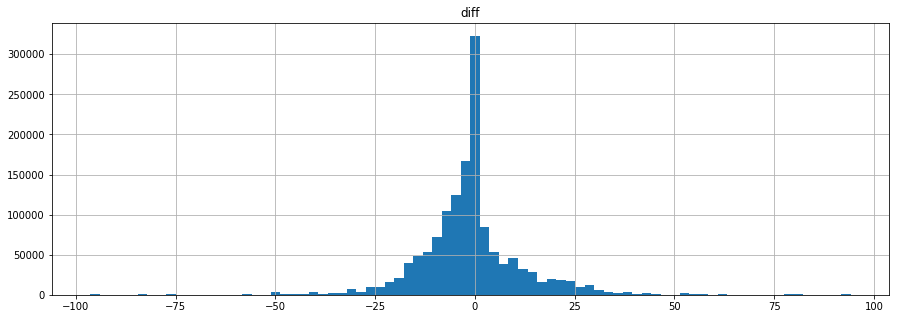

In [110]:
calc_pred_noZeros.hist(column='diff',bins=80,figsize=(15,5))

In [102]:
mean_error = calc_pred_noZeros['diff'].mean()
mean_error

-1.0835523970173073

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c879eaf98>]],
      dtype=object)

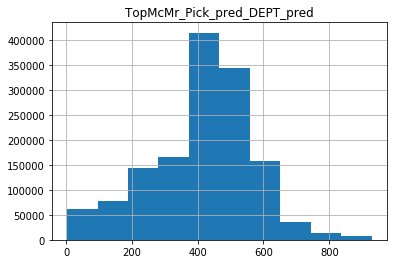

In [103]:
calc_pred_noZeros.hist(column='TopMcMr_Pick_pred_DEPT_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c87a28ac8>]],
      dtype=object)

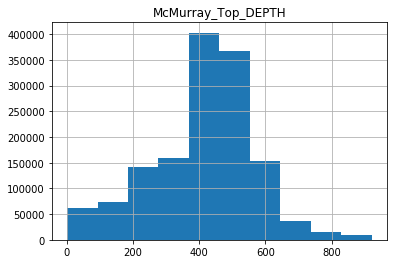

In [104]:
calc_pred_noZeros.hist(column='McMurray_Top_DEPTH')

In [386]:
df_results_train2_FullCol_vB.head()

,CALI,COND,DELT,DENS,DEPT,DEPTH,DPHI,DPHI:1,DPHI:2,DT,GR,GR:1,GR:2,IL,ILD,ILD:1,ILD:2,ILM,LITH,LLD,LLS,NPHI,PHID,PHIN,RESD,RHOB,RT,SFL,SFLU,SN,SNP,SP,UWI,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz,diff_TMcM_Pick_v_DEPT,diff_TPal_Pick_v_DEPT,cat_isTopMcMrNearby_known,cat_isTopPalNearby_known,DistFrom_NN1_TopDepth_Abs,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,trainOrTest,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,167.003,NaN,NaN,NaN,149.602,NaN,0.227,NaN,NaN,NaN,102.473,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.348,235.058,0,0,210.058,True,False,149.602,396.102,0.00,246.50,246.5,FromTopWell,0.00,0,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,102.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,test,0,0
1,199.159,NaN,NaN,NaN,149.852,NaN,0.263,NaN,NaN,NaN,122.589,NaN,NaN,NaN,4.202,NaN,NaN,NaN,NaN,NaN,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,112385,14000,13000,384.66,377.95,1,3,55.978836,-113.095365,389.0,414.0,25.0,359.66,13000,377.95,3,14000,384.66,1,228.098,234.808,0,0,209.808,False,False,149.602,396.102,0.25,246.25,246.5,FromTopWell,0.25,1,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.589,122.58

In [417]:
type(df_results_train2_FullCol_vB)

pandas.core.frame.DataFrame

In [441]:
test_9 = df_results_train2_FullCol_vB.copy()

In [442]:
test_9['testA'] = test_9.groupby(['UWI'])['TopMcMr_Pick_pred'].shift(-6).rolling(12).mean().fillna(0)

In [ ]:
test_df_1well['rollingMeanTopMcMrPred_12'] = test_df_1well.TopMcMr_Pick_pred.shift(-6).rolling(12).mean().fillna(0)

In [ ]:
df_TestGroupby_4 = df_TestGroupby.groupby(['UWI'])

In [436]:
df_TestGroupby_4 = df_TestGroupby.copy()

In [437]:
df_TestGroupby_4['testA'] = df_TestGroupby_4.groupby(['UWI'])['TopMcMr_Pick_pred'].shift(-6).rolling(12).mean().fillna(0)

In [438]:
df_TestGroupby_4['testB'] = df_TestGroupby_4.groupby(['UWI'])['TopMcMr_Pick_pred'].shift(-3).rolling(6).mean().fillna(0)

In [439]:
df_TestGroupby_4['testAplusB'] = df_TestGroupby_4['testA'] + df_TestGroupby_4['testB']

In [440]:
type(df_TestGroupby_4)

pandas.core.frame.DataFrame

In [415]:
df_TestGroupby_4

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,testA,testB,testAplusB
0,00/10-32-080-20W4/0,149.602,0,0,0,0.000000,0.000000,0.000000
1,00/10-32-080-20W4/0,149.852,0,0,0,0.000000,0.000000,0.000000
2,00/10-32-080-20W4/0,150.102,0,0,0,0.000000,0.000000,0.000000
3,00/10-32-080-20W4/0,150.352,0,0,0,0.000000,0.000000,0.000000
4,00/10-32-080-20W4/0,150.602,0,0,0,0.000000,0.000000,0.000000
5,00/10-32-080-20W4/0,150.852,0,0,0,0.000000,0.000000,0.000000
6,00/10-32-080-20W4/0,151.102,0,0,0,0.000000,0.000000,0.000000
7,00/10-32-080-20W4/0,151.352,0,0,0,0.000000,0.000000,0.000000
8,00/10-32-080-20W4/0,151.602,0,0,0,0.000000,0.000000,0.000000
9,00/10-32-080-20W4/0,151.852,0,0,0,0.000000,0.000000,0.000000


In [321]:
df_TestGroupby_4['test7'] = df_TestGroupby_4.groupby(['UWI'])['testAplusB'].max()

In [322]:
df_TestGroupby_4

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,test,testA,testB,testAplusB,temp_sum_max,test7
0,00/10-32-080-20W4/0,149.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,00/10-32-080-20W4/0,149.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,00/10-32-080-20W4/0,150.102,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,00/10-32-080-20W4/0,150.352,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,00/10-32-080-20W4/0,150.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
5,00/10-32-080-20W4/0,150.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
6,00/10-32-080-20W4/0,151.102,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
7,00/10-32-080-20W4/0,151.352,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
8,00/10-32-080-20W4/0,151.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,00/10-32-080-20W4/0,151.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [316]:
test8 = test7.to_frame()

In [317]:
len(test8)

1907

In [318]:
type(test8)

pandas.core.frame.DataFrame

In [319]:
df_TestGroupby_5 = pd.merge(df_TestGroupby_4,test8, on='UWI', how='outer')

In [320]:
df_TestGroupby_5

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,test,testA,testB,testAplusB_x,temp_sum_max,testAplusB_y
0,00/10-32-080-20W4/0,149.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
1,00/10-32-080-20W4/0,149.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
2,00/10-32-080-20W4/0,150.102,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
3,00/10-32-080-20W4/0,150.352,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
4,00/10-32-080-20W4/0,150.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
5,00/10-32-080-20W4/0,150.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
6,00/10-32-080-20W4/0,151.102,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
7,00/10-32-080-20W4/0,151.352,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
8,00/10-32-080-20W4/0,151.602,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5
9,00/10-32-080-20W4/0,151.852,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,187.5


In [307]:
###00/06-09-083-03W4/0
##test = df_TestGroupby_4['UWI'].where(df_TestGroupby_4['UWI'] == '00/06-09-083-03W4/0')
df_TestGroupby_4.loc[df_TestGroupby_4['UWI'] == '00/06-09-083-03W4/0']

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,test,testA,testB,testAplusB
724278,00/06-09-083-03W4/0,300.000,0,0,0,0.0,0.0,0.0,0.0
724279,00/06-09-083-03W4/0,300.820,0,0,0,0.0,0.0,0.0,0.0
724280,00/06-09-083-03W4/0,301.640,0,0,0,0.0,0.0,0.0,0.0
724281,00/06-09-083-03W4/0,302.461,0,0,0,0.0,0.0,0.0,0.0
724282,00/06-09-083-03W4/0,303.281,0,0,0,0.0,0.0,0.0,0.0
724283,00/06-09-083-03W4/0,304.101,0,0,0,0.0,0.0,0.0,0.0
724284,00/06-09-083-03W4/0,304.921,0,0,0,0.0,0.0,0.0,0.0
724285,00/06-09-083-03W4/0,305.741,0,0,0,0.0,0.0,0.0,0.0
724286,00/06-09-083-03W4/0,306.562,0,0,0,0.0,0.0,0.0,0.0
724287,00/06-09-083-03W4/0,307.382,0,0,0,0.0,0.0,0.0,0.0


In [278]:
df_TestGroupby_3.head()

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
0,00/10-32-080-20W4/0,149.602,0,0,0
1,00/10-32-080-20W4/0,149.852,0,0,0
2,00/10-32-080-20W4/0,150.102,0,0,0
3,00/10-32-080-20W4/0,150.352,0,0,0
4,00/10-32-080-20W4/0,150.602,0,0,0
987,00/04-15-081-09W4/0,243.840,0,0,0
988,00/04-15-081-09W4/0,244.090,0,0,0
989,00/04-15-081-09W4/0,244.340,0,0,0
990,00/04-15-081-09W4/0,244.590,0,0,0
991,00/04-15-081-09W4/0,244.840,0,0,0


In [255]:
pickCol = 'TopMcMr_Pick_pred'

In [279]:
test6 = df_TestGroupby_3.apply(lambda x: x[pickCol].shift(-6).rolling(12).mean().fillna(0))

In [280]:
test6

UWI                         
00/01-01-073-05W5/0  759186      0.000000
                     759187      0.000000
                     759188      0.000000
                     759189      0.000000
                     759190      0.000000
                     759191      0.000000
                     759192      0.000000
                     759193      0.000000
                     759194      0.000000
                     759195      0.000000
                     759196      0.000000
                     759197      0.000000
                     759198      0.000000
                     759199      0.000000
                     759200      0.000000
                     759201      0.000000
                     759202      0.000000
                     759203      0.000000
                     759204      0.000000
                     759205      0.000000
                     759206      0.000000
                     759207      0.000000
                     759208      0.000000
     

In [ ]:
merged = pd.merge(df_TestGroupby,test6, on='UWI', how='outer')

In [281]:
test6.reset_index()

,UWI,level_1,TopMcMr_Pick_pred
0,00/01-01-073-05W5/0,759186,0.000000
1,00/01-01-073-05W5/0,759187,0.000000
2,00/01-01-073-05W5/0,759188,0.000000
3,00/01-01-073-05W5/0,759189,0.000000
4,00/01-01-073-05W5/0,759190,0.000000
5,00/01-01-073-05W5/0,759191,0.000000
6,00/01-01-073-05W5/0,759192,0.000000
7,00/01-01-073-05W5/0,759193,0.000000
8,00/01-01-073-05W5/0,759194,0.000000
9,00/01-01-073-05W5/0,759195,0.000000


In [282]:
test6

UWI                         
00/01-01-073-05W5/0  759186      0.000000
                     759187      0.000000
                     759188      0.000000
                     759189      0.000000
                     759190      0.000000
                     759191      0.000000
                     759192      0.000000
                     759193      0.000000
                     759194      0.000000
                     759195      0.000000
                     759196      0.000000
                     759197      0.000000
                     759198      0.000000
                     759199      0.000000
                     759200      0.000000
                     759201      0.000000
                     759202      0.000000
                     759203      0.000000
                     759204      0.000000
                     759205      0.000000
                     759206      0.000000
                     759207      0.000000
                     759208      0.000000
     

In [274]:
test6 = test6.drop(columns=['level_1'])

In [275]:
test6

UWI                         
00/01-01-073-05W5/0  759186      0.000000
                     759187      0.000000
                     759188      0.000000
                     759189      0.000000
                     759190      0.000000
                     759191      0.000000
                     759192      0.000000
                     759193      0.000000
                     759194      0.000000
                     759195      0.000000
                     759196      0.000000
                     759197      0.000000
                     759198      0.000000
                     759199      0.000000
                     759200      0.000000
                     759201      0.000000
                     759202      0.000000
                     759203      0.000000
                     759204      0.000000
                     759205      0.000000
                     759206      0.000000
                     759207      0.000000
                     759208      0.000000
     

In [ ]:
test6.columns = ["UWI", "predTopMcMr_rollMean12"]

In [ ]:
test6

In [ ]:
merged = pd.merge(df_TestGroupby,test6, on='UWI', how='outer')

In [206]:
df_results_train2_FullCol_vB = pd.concat([preSplitpreBal,df_results_train2_], axis=1)

In [207]:
df_TestGroupby = df_results_train2_FullCol_vB[['UWI','DEPT','cat_isTopMcMrNearby_known','TopMcMr_Pick_pred']]

In [209]:
df_TestGroupby_2 = df_TestGroupby.groupby(['UWI'])

In [210]:
df_TestGroupby_2

In [212]:
len(df_TestGroupby_2)

1907

In [239]:
test5 = df_TestGroupby_2.apply(lambda x: findMiddleOfPreClassif(x['DEPT'].values,x['TopMcMr_Pick_pred'].values))

In [240]:
test5 = test5.reset_index()

In [241]:
test5.columns = ["UWI", "predTopMcMr_P50"]
# test5.rename(columns = {'two':'new_name'})

In [242]:
test5

,UWI,predTopMcMr_P50
0,00/01-01-073-05W5/0,629.000
1,00/01-03-085-15W4/0,235.301
2,00/01-04-075-23W4/0,623.500
3,00/01-05-085-15W4/0,260.000
4,00/01-08-080-21W4/0,431.500
5,00/01-09-080-13W4/0,448.500
6,00/01-10-078-26W4/0,540.750
7,00/01-11-082-23W4/0,425.500
8,00/01-12-079-14W4/0,456.000
9,00/01-21-084-17W4/0,272.301


In [237]:
test5.columns

['UWI', 'predTopMcMr_P50']

In [243]:
test5.head()

,UWI,predTopMcMr_P50
0,00/01-01-073-05W5/0,629.000
1,00/01-03-085-15W4/0,235.301
2,00/01-04-075-23W4/0,623.500
3,00/01-05-085-15W4/0,260.000
4,00/01-08-080-21W4/0,431.500


In [245]:
merged = pd.merge(df_TestGroupby,test5, on='UWI', how='outer')

In [253]:
merged[10400:10700]

,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred,predTopMcMr_P50
10400,00/10-22-076-03W4/0,404.08,0,0,0,429.33
10401,00/10-22-076-03W4/0,404.33,0,0,0,429.33
10402,00/10-22-076-03W4/0,404.58,0,0,0,429.33
10403,00/10-22-076-03W4/0,404.83,0,0,0,429.33
10404,00/10-22-076-03W4/0,405.08,0,0,0,429.33
10405,00/10-22-076-03W4/0,405.33,0,0,0,429.33
10406,00/10-22-076-03W4/0,405.58,0,0,0,429.33
10407,00/10-22-076-03W4/0,405.83,0,0,0,429.33
10408,00/10-22-076-03W4/0,406.08,0,0,0,429.33
10409,00/10-22-076-03W4/0,406.33,0,0,0,429.33


In [223]:
test6 = pd.concat([test5, df_TestGroupby], axis=1, sort=False)

In [224]:
test6.head()

,0,UWI,DEPT,cat_isTopMcMrNearby_known,cat_isTopMcMrNearby_known,TopMcMr_Pick_pred
00/01-01-073-05W5/0,629.000,NaN,NaN,NaN,NaN,NaN
00/01-03-085-15W4/0,235.301,NaN,NaN,NaN,NaN,NaN
00/01-04-075-23W4/0,623.500,NaN,NaN,NaN,NaN,NaN
00/01-05-085-15W4/0,260.000,NaN,NaN,NaN,NaN,NaN
00/01-08-080-21W4/0,431.500,NaN,NaN,NaN,NaN,NaN


In [217]:
test_5b = test_5.reset_index()

In [218]:
test_5b 

,UWI,0
0,00/01-01-073-05W5/0,629.000
1,00/01-03-085-15W4/0,235.301
2,00/01-04-075-23W4/0,623.500
3,00/01-05-085-15W4/0,260.000
4,00/01-08-080-21W4/0,431.500
5,00/01-09-080-13W4/0,448.500
6,00/01-10-078-26W4/0,540.750
7,00/01-11-082-23W4/0,425.500
8,00/01-12-079-14W4/0,456.000
9,00/01-21-084-17W4/0,272.301


In [ ]:
def getMedianInGroupbyApply(df,depth_str,pick_pred_class_str):
    asdf

In [ ]:
predicted_from_median_pick = findMiddle(test_df_1well['DEPT'].values,test_df_1well['TopMcMr_Pick_pred'].values)
